In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the data
V_North, V_South = np.loadtxt("../Vela_Pulsar_data_Ooty_telescope/ch00_B0833-45_20150612_191438_010_4",unpack=True)

In [39]:
params={'axes.titlesize':25,
         'xtick.labelsize':18,
         'ytick.labelsize':18,'axes.labelsize':25}
plt.rcParams.update(params)

### I - Verify that the raw voltage distribution is gaussian

We will select 100 000 random voltage samples to make sure the pulsar does not signal does not bias our estimations 


In [3]:
# Select 100 000 random samples from each feed
index1 = np.random.randint(0, len(V_North),100000)
index2 = np.random.randint(0, len(V_South),100000)

rand_north = V_North[index1]
rand_south = V_South[index2]

In [4]:
# Estimate the mean and std
mean1 = np.mean(rand_north)
std1 = np.std(rand_north)

mean2 = np.mean(rand_south)
std2 = np.std(rand_south)

In [45]:
16.5/256

0.064453125

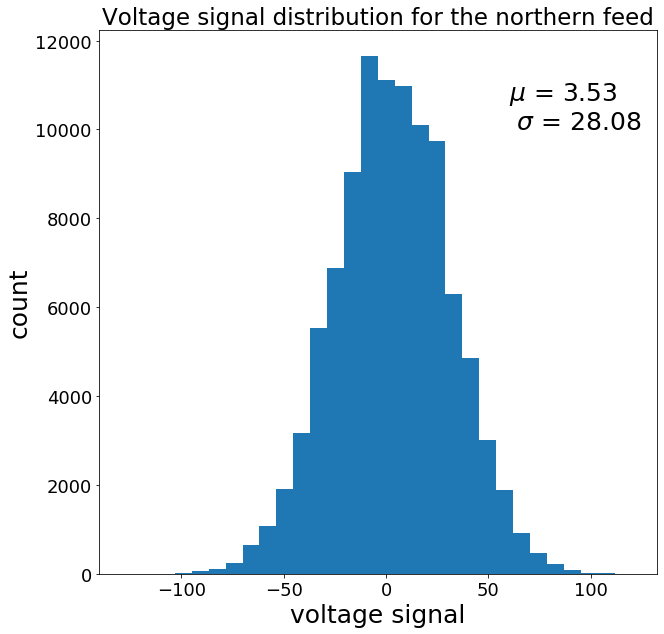

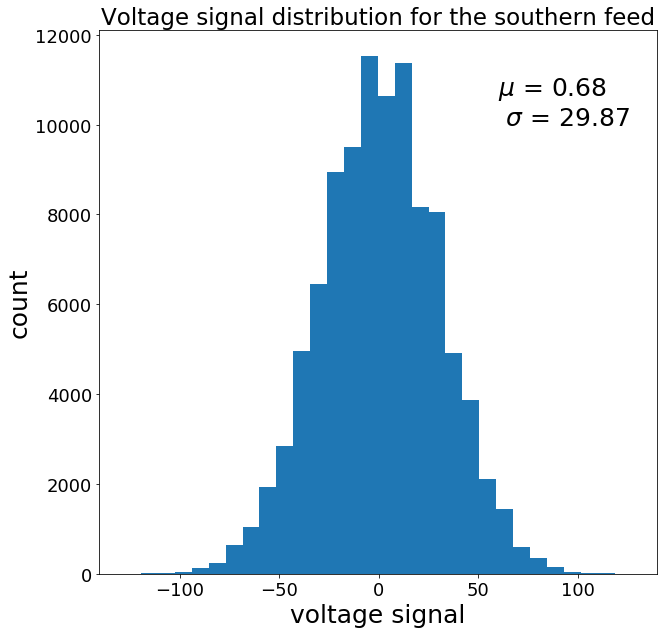

In [167]:
# Visualize the distribution
fig1 = plt.figure(figsize= [10,10])

plt.hist(rand_north, bins = 30)
plt.title('Voltage signal distribution for the northern feed', fontsize = 23)
plt.ylabel('count')
plt.xlabel('voltage signal')
plt.text(60,10000,'$\mu$ = %.2f \n $\sigma$ = %.2f'%(mean1, std1), fontsize = 25)
plt.savefig('NorthernV')

fig2 = plt.figure(figsize= [10,10])
plt.hist(rand_south, bins = 30)
plt.title('Voltage signal distribution for the southern feed', fontsize = 23)
plt.ylabel('count')
plt.xlabel('voltage signal')
plt.text(60,10000,'$\mu$ = %.2f \n $\sigma$ = %.2f'%(mean2, std2), fontsize = 25)
plt.savefig('SouthernV')

### II - Dynamic spectrum

The following steps describe how we get the dynamic spectrum

In [52]:
class Voltage_Ooty():
    
    # Step 1: Take 512 points at a time and apply fourier transform
    def points_to_FFT(self, Voltage, n_points = 512):
        length = int(len(Voltage)/n_points)
    
        return Voltage.reshape((length, n_points))
    
    # Step 2: compute the fast fourier transform for each 512 points
    def FFT(self, Voltage):
        Fourier = []
        for i in range(len(Voltage)):
            Fourier.append(np.fft.fft(Voltage[i]))
        return np.array(Fourier)
    
    # Step 3: Take half of the spectrum and compute modulus square
    def modulus(self, spec):
    
        # Calculate modulus
        modulus = []
        for i in range(len(spec)):
        
            modulus.append(np.absolute(spec[i][0:int(spec.shape[1]/2)]))
    
        return np.array(modulus)
    
    # Step 4: average based on the desired time resolution 
    # For now let's keep 1 ms 
    def average(self, spec, n_avg = 60):
    
        average = []
    
        for i in range(n_avg, len(spec) + n_avg, n_avg):
            to_sum = spec[i - n_avg:i]
            average.append(to_sum.mean(axis = 0))

        return np.array(average)
    
    # Apply all steps
    def get_ds(self, data):
        
        x = self.points_to_FFT(data)
        x = self.FFT(x)
        x = self.modulus(x)
        return self.average(x)
    
       
    # If we want to correlate the signals
    def correlate(self, v1, v2):
        
        x1 = self.FFT(self.points_to_FFT(v1))
        x2 = self.FFT(self.points_to_FFT(v2))
        
        # Correlate the signals by multiplying N by the conjugate of S chan by chan
        corr = []
        for i in range(len(x1)):
            
            corr.append((x1[i])*np.conjugate(x2[i]))
        
        corr = np.array(corr)
        
        # Proceed to modulus
        corr = self.modulus(corr)
        
        return self.average(corr)

In [53]:
process = Voltage_Ooty()

In [54]:
# Get the dynamic spectrum for both north and southern feeds
ds_north = process.get_ds(V_North)
ds_south = process.get_ds(V_South)

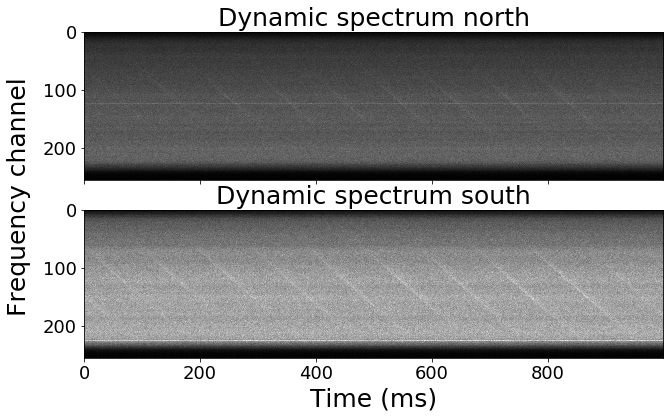

In [162]:
# Visualize the result
fig , axes = plt.subplots(2, sharex=True, figsize = [11,6])
fig.text(0.05, 0.5, 'Frequency channel', va='center', rotation='vertical', fontsize = 25)
plt.xlabel('Time (ms)')
#plt.ylabel('Frequency channel')
#plt.xlabel('Time (ms)')
#fig.add_subplot(2,1,1)
axes[0].imshow(ds_north.transpose(), cmap='gray')
axes[0].set_title('Dynamic spectrum north')
#plt.savefig('ds_north')
#fig.add_subplot(2,1,2)
axes[1].imshow(ds_south.transpose(), cmap='gray')
axes[1].set_title('Dynamic spectrum south')
#plt.savefig('ds_south')

for i in axes:
    ax.label_outer()

plt.savefig('ds_both')

In [65]:
# Visualize the correlated signal
ds_corr = process.correlate(V_North,V_South)

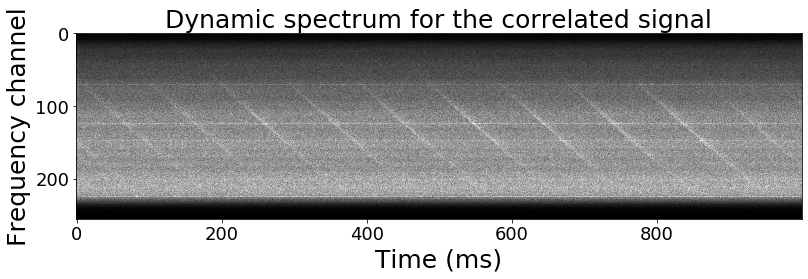

In [169]:
plt.figure(figsize = [13,10])
plt.imshow(ds_corr.transpose(), cmap='gray')
plt.title('Dynamic spectrum for the correlated signal')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency channel')
plt.savefig('correlated_sig')

In [50]:
# Save in a txt file 
np.savetxt('Dispersedpulses.txt', ds_corr, delimiter= ',')